In [57]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.dates as mdates
import json

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = [5.0, 3.0]
plt.rcParams['figure.dpi'] = 150
%matplotlib notebook

In [20]:
true_data = pd.read_csv("csv_data/srilanka.txt",sep=' ', skipinitialspace=True, \
                        skiprows=1, header=None, names=['confirmed', 'recovered', 'deaths'])
true_data

,confirmed,recovered,deaths
0,3382,3233,13
1,3388,3245,13
2,3395,3254,13
3,3402,3258,13
4,3513,3259,13
...,...,...,...
370,522778,0,13185
371,523550,0,13229
372,524937,0,13267
373,525663,0,13296


In [21]:
smoothed_data = pd.read_csv("../C++/build/release/results/srilanka_popsmooth.txt", skipinitialspace=True, \
                            header=None, names=['confirmed_true', 'deaths_true', 'confirmed_smooth', 'deaths_smooth'])
diff_data = smoothed_data.diff();
diff_data.loc[0] = 0
smoothed_data

,confirmed_true,deaths_true,confirmed_smooth,deaths_smooth
0,3382,13,3382,13
1,3388,13,3388,13
2,3395,13,3416,13
3,3402,13,3684,13
4,3513,13,3842,13
...,...,...,...,...
370,522778,13185,522940,13183
371,523550,13229,523790,13222
372,524937,13267,524662,13262
373,525663,13296,525661,13298


<IPython.core.display.Javascript object>


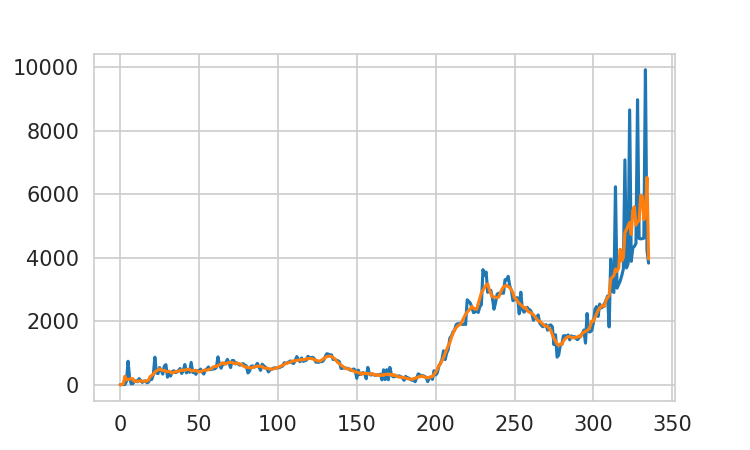

In [18]:
plt.figure()
plt.plot(diff_data['confirmed_true'])
plt.plot(diff_data['confirmed_smooth'])
plt.show()

<IPython.core.display.Javascript object>


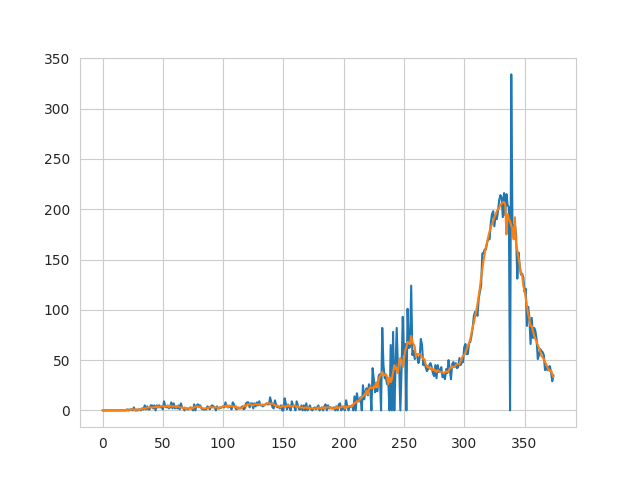

In [4]:
plt.figure()
plt.plot(diff_data['deaths_true'])
plt.plot(diff_data['deaths_smooth'])
plt.show()

In [63]:
pred_data = pd.read_csv("../C++/build/release/results/srilanka_prediction_seed1.txt", \
                        skipinitialspace=True)
#print("pred_data:\n", pred_data)
num_days = len(pred_data)
print("Num days:", num_days)

param_data = pd.read_csv("../C++/build/release/results/srilanka_params_seed1.txt", \
                        skipinitialspace=True,header=None)
# param_data = param_data.iloc[:, ::-1];
#print(param_data)

beta = param_data.loc[0:num_days-1]
c0 = param_data.loc[  num_days:2*num_days-1]
c1 = param_data.loc[2*num_days:3*num_days-1]
c2 = param_data.loc[3*num_days:4*num_days-1]
c3 = param_data.loc[4*num_days:5*num_days-1]
IFR = param_data.loc[5*num_days:6*num_days-1]
#print(IFR[0])

num_sol_to_plot = min(4, len(param_data.columns));

vaccine_eff = param_data.loc[param_data.index[-2]]
print("Vaccine effectiveness:\n",vaccine_eff)

optimal_params = {
    "beta": beta[0].tolist(),
    "c0"  : c0[0].tolist(),
    "c1"  : c1[0].tolist(),
    "c2"  : c2[0].tolist(),
    "c3"  : c3[0].tolist(),
    "IFR"  : IFR[0].tolist(),
    "vaccine_eff": vaccine_eff[0]
}

#Write optimal parameters as JS variable
opt_param_json_file = open("optimal_parameters.js", "w")
opt_param_json_file.write("let optimal_model_params = ")
json.dump(optimal_params, opt_param_json_file)
opt_param_json_file.close()

error = param_data.loc[param_data.index[-1]]
error_plot = error[0:num_sol_to_plot]
print("Error:\n",error)

scaled_error = (np.log(error_plot) - np.log(min(error_plot))) / (np.log(max(error_plot)) - np.log(min(error_plot))) * 0.9
print("Scaled error:\n", scaled_error)
grey_colors = np.tile(scaled_error,[3,1]).transpose();

# grey_colormap = matplotlib.colors.ListedColormap(grey_colors)
grey_colors[0] = [0.24, 0.63, 0.93] #Change color of best result to blue
print("Grey colors:\n", grey_colors)
# plt.figure()
# ax = sns.heatmap(np.random.rand(30,30))
# ax.pcolor(np.random.rand(30,30),cmap=grey_colormap)
# plt.show()

start_date = datetime.strptime("2020-10-1", "%Y-%m-%d")
dates = [];
for i in range(0,num_days):
    dates.append(start_date + timedelta(days=i))

locator = mdates.AutoDateLocator(minticks=4, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)

Num days: 375
Vaccine effectiveness:
 0     0.907787
1     0.573778
2     0.538609
3     0.429810
4     0.494626
5     0.802317
6     0.723171
7     0.720648
8     1.000000
9     0.859291
10    0.929875
11    0.774418
12    0.613919
13    0.750633
14    0.919012
15    0.400000
16    0.475789
17    0.400000
18    0.627882
19    0.400000
Name: 2259, dtype: float64
Error:
 0     0.000137
1     0.000247
2     0.000250
3     0.000282
4     0.000307
5     0.000366
6     0.000422
7     0.020982
8     0.497027
9     0.822706
10    0.842951
11    0.845755
12    0.888325
13    0.902548
14    0.906570
15    0.922423
16    0.967787
17    0.969032
18    1.958953
19    1.973337
Name: 2260, dtype: float64
Scaled error:
 0    0.000000
1    0.730557
2    0.749156
3    0.900000
Name: 2260, dtype: float64
Grey colors:
 [[0.24       0.63       0.93      ]
 [0.73055664 0.73055664 0.73055664]
 [0.74915597 0.74915597 0.74915597]
 [0.9        0.9        0.9       ]]


<IPython.core.display.Javascript object>


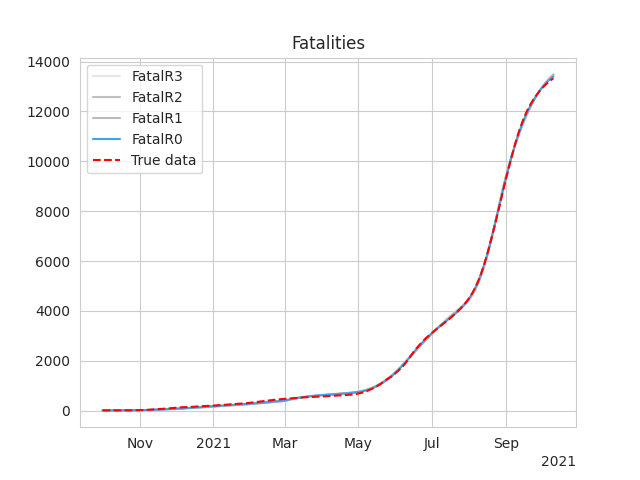

In [30]:
pred_fatal = pred_data.filter(regex=("FatalR.*"))

fig = plt.figure()

for i in range(num_sol_to_plot-1,-1,-1):
    plt.plot(dates,pred_fatal["FatalR"+str(i)], color=grey_colors[i])
    
plt.plot(dates,smoothed_data["deaths_smooth"],'r--')
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
    
labels = pred_fatal.columns[0:num_sol_to_plot][::-1].tolist();
labels.append("True data");
plt.legend(labels,loc='upper left')
plt.title('Fatalities')
plt.show()


<IPython.core.display.Javascript object>


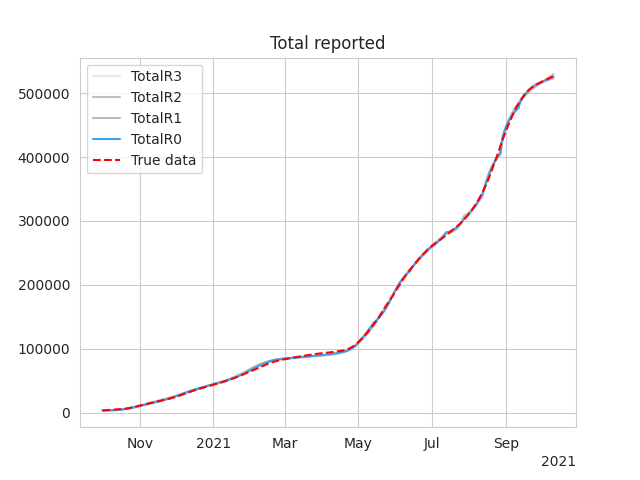

In [31]:
pred_reported = pred_data.filter(regex=("TotalR.*"))
# print(pred_reported)

plt.figure()

for i in range(num_sol_to_plot-1,-1,-1):
    plt.plot(dates, pred_reported["TotalR"+str(i)], color=grey_colors[i])

# plt.plot(pred_reported)
plt.plot(dates, smoothed_data["confirmed_smooth"],'r--')
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

labels = pred_reported.columns[0:num_sol_to_plot][::-1].tolist();
labels.append("True data");
plt.legend(labels,loc='upper left')
plt.title('Total reported')
plt.show()

<IPython.core.display.Javascript object>


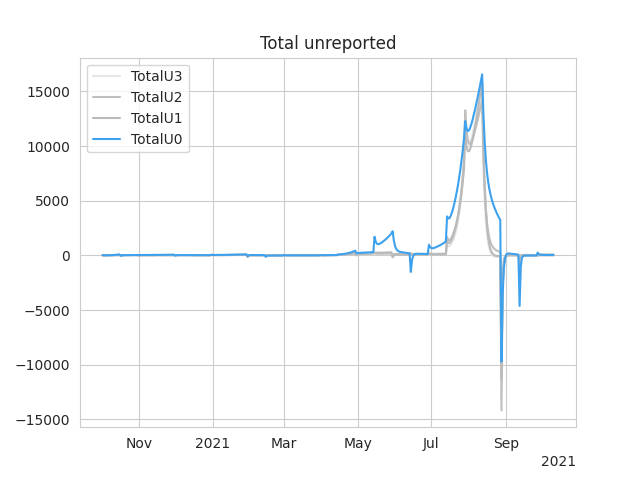

In [32]:
pred_unreported = pred_data.filter(regex=("TotalU.*"))
# print(pred_unreported)

plt.figure()

for i in range(num_sol_to_plot-1,-1,-1):
    plt.plot(dates, pred_unreported["TotalU"+str(i)].diff(), color=grey_colors[i])

ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

labels = pred_unreported.columns[0:num_sol_to_plot][::-1].tolist();
plt.legend(labels,loc='upper left')
plt.title('Total unreported')
plt.show()

        Reff0     Reff1     Reff2     Reff3     Reff4     Reff5     Reff6  \
0    0.372311  0.618738  0.493309  0.857044  0.677693  0.651436  0.484891   
1    0.372311  0.618738  0.493309  0.857043  0.677692  0.651435  0.484890   
2    0.372311  0.618737  0.493308  0.857042  0.677691  0.651434  0.484889   
3    0.372310  0.618735  0.493307  0.857040  0.677690  0.651432  0.484888   
4    0.372309  0.618734  0.493305  0.857038  0.677688  0.651431  0.484887   
..        ...       ...       ...       ...       ...       ...       ...   
370  0.519000  0.592764  0.533965  0.687711  0.591834  0.516215  0.535426   
371  0.518981  0.592722  0.533952  0.687656  0.591793  0.516212  0.535425   
372  0.518961  0.592679  0.533938  0.687598  0.591750  0.516210  0.535425   
373  0.518942  0.592636  0.533926  0.687537  0.591705  0.516208  0.535424   
374  0.518923  0.592592  0.533914  0.687473  0.591659  0.516207  0.535423   

        Reff7     Reff8     Reff9    Reff10    Reff11    Reff12    Reff13  

<IPython.core.display.Javascript object>


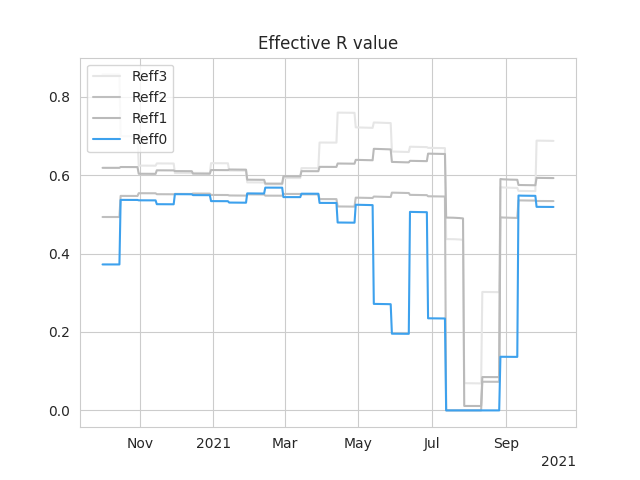

In [33]:
pred_Reff = pred_data.filter(regex=("Reff.*"))
print(pred_Reff)

plt.figure()

for i in range(num_sol_to_plot-1,-1,-1):
    plt.plot(dates, pred_Reff["Reff"+str(i)], color=grey_colors[i])

ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)

labels = pred_Reff.columns[0:num_sol_to_plot][::-1].tolist();
plt.legend(labels,loc='upper left')
plt.title('Effective R value')
plt.show()

<IPython.core.display.Javascript object>


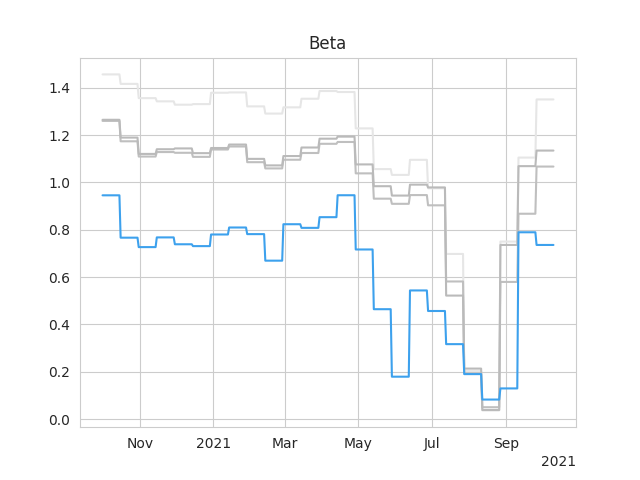

<IPython.core.display.Javascript object>


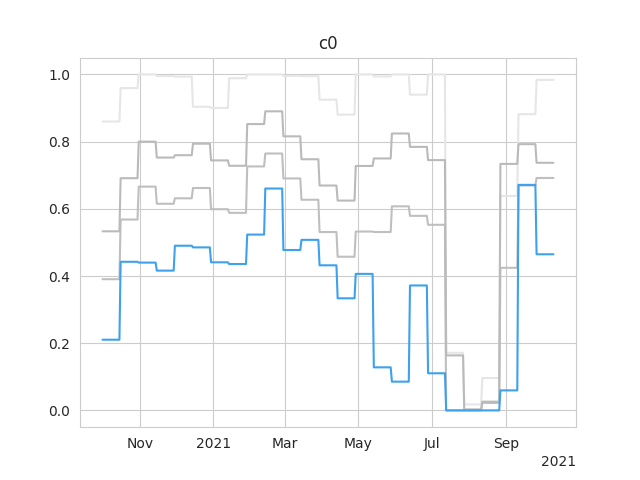

<IPython.core.display.Javascript object>


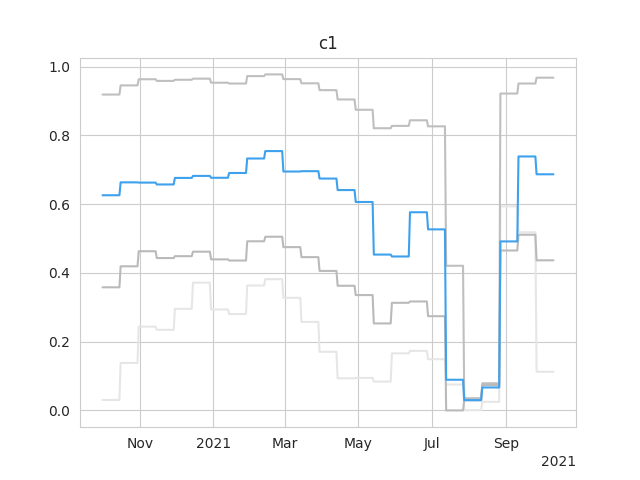

In [47]:
plt.figure()
for i in range(num_sol_to_plot-1,-1,-1):
    plt.plot(dates, beta[i], color=grey_colors[i])
# sns.lineplot(data=beta,palette=grey_colormap, dashes=False)
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.title('Beta')
plt.show()

plt.figure()
for i in range(num_sol_to_plot-1,-1,-1):
    plt.plot(dates, c0[i], color=grey_colors[i])
# sns.lineplot(data=c0,palette="Greys_r", dashes=False)
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.title('c0')
plt.show()

plt.figure()
for i in range(num_sol_to_plot-1,-1,-1):
    plt.plot(dates, c1[i], color=grey_colors[i])
# sns.lineplot(data=c1,palette="ch:s=.25,rot=-.25,reverse=1", dashes=False)
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.title('c1')
plt.show()

# print(sns.color_palette("light:#5A9")[0])

<IPython.core.display.Javascript object>


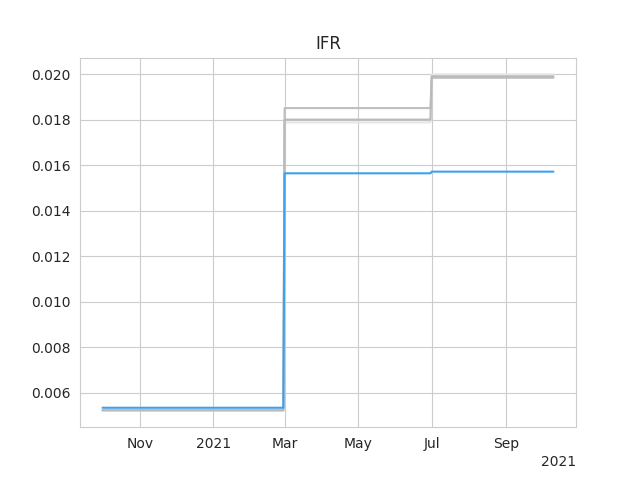

In [35]:
plt.figure()
for i in range(num_sol_to_plot-1,-1,-1):
    plt.plot(dates, IFR[i], color=grey_colors[i])
# sns.lineplot(data=IFR,palette="ch:s=.25,rot=-.25,reverse=1", dashes=False)
ax = plt.gca()
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
plt.title('IFR')
plt.show()